# Телекоммуникации. Финальный проект

## Описание проекта

### Цель проекта
Предсказание оттока клиентов. Модель будет предсказывать, разорвёт ли абонент договор, чтобы сотрудники начали предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Нужно для удержания клиентов.

### Описание услуг
Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

### Описание данных
Данные состоят из нескольких файлов, полученных из разных источников:\
`contract_new.csv` — информация о договоре;\
`personal_new.csv` — персональные данные клиента;\
`internet_new.csv` — информация об интернет-услугах;\
`phone_new.csv` — информация об услугах телефонии.

Файл `contract_new.csv`\
`customerID` — идентификатор абонента;\
`BeginDate` — дата начала действия договора;\
`EndDate` — дата окончания действия договора;\
`Type` — тип оплаты: раз в год-два или ежемесячно;\
`PaperlessBilling` — электронный расчётный лист;\
`PaymentMethod` — тип платежа;\
`MonthlyCharges` — расходы за месяц;\
`TotalCharges` — общие расходы абонента.

Файл `personal_new.csv`\
`customerID` — идентификатор пользователя;\
`gender` — пол;\
`SeniorCitizen` — является ли абонент пенсионером;\
`Partner` — есть ли у абонента супруг или супруга;\
`Dependents` — есть ли у абонента дети.

Файл `internet_new.csv`\
`customerID` — идентификатор пользователя;\
`InternetService` — тип подключения;\
`OnlineSecurity` — блокировка опасных сайтов;\
`OnlineBackup` — облачное хранилище файлов для резервного копирования данных;\
`DeviceProtection` — антивирус;\
`TechSupport` — выделенная линия технической поддержки;\
`StreamingTV` — стриминговое телевидение;\
`StreamingMovies` — каталог фильмов.

Файл `phone_new.csv`\
`customerID` — идентификатор пользователя;\
`MultipleLines` — подключение телефона к нескольким линиям одновременно.\
Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

### План работы
Шаг 1. Загрузка данных, первичный осмотр и предобработка данных \
Шаг 2. Объединение данных и предобработка данных объединённого датафрейма. Создание новых признаков \
Шаг 3. Исследовательский анализ данных \
Шаг 4. Подготовка данных \
Шаг 5. Обучение моделей машинного обучения \
Шаг 6. Выбор лучшей модели. Анализ признаков, матрица ошибок \
Шаг 7. Общий вывод и рекомендации заказчику

## Первичный осмотр данных и их загрузка

### Загрузка данных

In [1]:
!pip install phik
!pip install scikit-learn -U
!pip install shap 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import phik
import shap

from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer 

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from catboost import CatBoostClassifier

In [3]:
pth1 = '/datasets/contract_new.csv'
pth2 = '/datasets/personal_new.csv'
pth3 = '/datasets/internet_new.csv'
pth4 = '/datasets/phone_new.csv'

if os.path.exists(pth1):
    contract = pd.read_csv(pth1, parse_dates=['BeginDate'], index_col='customerID')
if os.path.exists(pth2):
    personal = pd.read_csv(pth2, index_col='customerID')
if os.path.exists(pth3):
    internet = pd.read_csv(pth3, index_col='customerID')
if os.path.exists(pth4):
    phone = pd.read_csv(pth4, index_col='customerID')
else:
    print('Something is wrong')

### contract_new

In [4]:
contract.head()

BeginDate EndDate            Type PaperlessBilling  \
customerID                                                       
7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
5575-GNVDE 2017-04-01      No        One year               No   
3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
7795-CFOCW 2016-05-01      No        One year               No   
9237-HQITU 2019-09-01      No  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges TotalCharges  
customerID                                                          
7590-VHVEG           Electronic check           29.85        31.04  
5575-GNVDE               Mailed check           56.95      2071.84  
3668-QPYBK               Mailed check           53.85       226.17  
7795-CFOCW  Bank transfer (automatic)           42.30       1960.6  
9237-HQITU           Electronic check           70.70        353.5

In [5]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
report = contract.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / contract.shape[0]).round(2)*100
report.sort_values(by = 'missing_values', ascending = False)

missing_values  % of total
TotalCharges                  11         0.0
BeginDate                      0         0.0
EndDate                        0         0.0
Type                           0         0.0
PaperlessBilling               0         0.0
PaymentMethod                  0         0.0
MonthlyCharges                 0         0.0

Есть 11 пропущенных значений в столбце 'TotalCharges', исследуем их

In [6]:
contract[contract['TotalCharges'].isna()]

BeginDate EndDate      Type PaperlessBilling  \
customerID                                                 
4472-LVYGI 2020-02-01      No  Two year              Yes   
3115-CZMZD 2020-02-01      No  Two year               No   
5709-LVOEQ 2020-02-01      No  Two year               No   
4367-NUYAO 2020-02-01      No  Two year               No   
1371-DWPAZ 2020-02-01      No  Two year               No   
7644-OMVMY 2020-02-01      No  Two year               No   
3213-VVOLG 2020-02-01      No  Two year               No   
2520-SGTTA 2020-02-01      No  Two year               No   
2923-ARZLG 2020-02-01      No  One year              Yes   
4075-WKNIU 2020-02-01      No  Two year               No   
2775-SEFEE 2020-02-01      No  Two year              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  
customerID                                                           
4472-LVYGI  Bank transfer (automatic)           52.55           NaN  
3115-CZMZD               Mailed check           20.25           NaN  
5709-LVOEQ               Mailed check           80.85           NaN  
4367-NUYAO               Mailed check           25.75           NaN  
1371-DWPAZ    Credit card (automatic)           56.05           NaN  
7644-OMVMY               Mailed check           19.85           NaN  
3213-VVOLG               Mailed check           25.35           NaN  
2520-SGTTA               Mailed check           20.00           NaN  
2923-ARZLG               Mailed check           19.70           NaN  
4075-WKNIU               Mailed check           73.35           NaN  
2775-SEFEE  Bank transfer (automatic)           61.90           NaN

`TotalCharges` пуст, если дата начала действия договора совпадает с датой выгрузки, т.е. это абоненты с длительностью контракта - 0 дней. Заменим там `TotalCharges` на 0.

In [7]:
contract = contract.fillna(0)

In [8]:
contract.head()

BeginDate EndDate            Type PaperlessBilling  \
customerID                                                       
7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
5575-GNVDE 2017-04-01      No        One year               No   
3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
7795-CFOCW 2016-05-01      No        One year               No   
9237-HQITU 2019-09-01      No  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  
customerID                                                           
7590-VHVEG           Electronic check           29.85         31.04  
5575-GNVDE               Mailed check           56.95       2071.84  
3668-QPYBK               Mailed check           53.85        226.17  
7795-CFOCW  Bank transfer (automatic)           42.30       1960.60  
9237-HQITU           Electronic check           70.70        353.50

In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 440.2+ KB


In [10]:
contract.describe()

MonthlyCharges  TotalCharges
count     7043.000000   7043.000000
mean        64.761692   2115.312885
std         30.090047   2112.742814
min         18.250000      0.000000
25%         35.500000    436.750000
50%         70.350000   1343.350000
75%         89.850000   3236.690000
max        118.750000   9221.380000

### personal_new

In [11]:
personal.head()

gender  SeniorCitizen Partner Dependents
customerID                                          
7590-VHVEG  Female              0     Yes         No
5575-GNVDE    Male              0      No         No
3668-QPYBK    Male              0      No         No
7795-CFOCW    Male              0      No         No
9237-HQITU  Female              0      No         No

In [12]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('object')

In [13]:
personal.head()

gender SeniorCitizen Partner Dependents
customerID                                         
7590-VHVEG  Female             0     Yes         No
5575-GNVDE    Male             0      No         No
3668-QPYBK    Male             0      No         No
7795-CFOCW    Male             0      No         No
9237-HQITU  Female             0      No         No

In [14]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   object
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: object(4)
memory usage: 275.1+ KB


In [15]:
personal.describe()

gender  SeniorCitizen Partner Dependents
count    7043           7043    7043       7043
unique      2              2       2          2
top      Male              0      No         No
freq     3555           5901    3641       4933

### internet_new

In [16]:
internet.head()

InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                
7590-VHVEG             DSL             No          Yes               No   
5575-GNVDE             DSL            Yes           No              Yes   
3668-QPYBK             DSL            Yes          Yes               No   
7795-CFOCW             DSL            Yes           No              Yes   
9237-HQITU     Fiber optic             No           No               No   

           TechSupport StreamingTV StreamingMovies  
customerID                                          
7590-VHVEG          No          No              No  
5575-GNVDE          No          No              No  
3668-QPYBK          No          No              No  
7795-CFOCW         Yes          No              No  
9237-HQITU          No          No              No

In [17]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [18]:
internet.describe()

InternetService OnlineSecurity OnlineBackup DeviceProtection  \
count             5517           5517         5517             5517   
unique               2              2            2                2   
top        Fiber optic             No           No               No   
freq              3096           3498         3088             3095   

       TechSupport StreamingTV StreamingMovies  
count         5517        5517            5517  
unique           2           2               2  
top             No          No              No  
freq          3473        2810            2785

### phone_new

In [19]:
phone.head()

MultipleLines
customerID              
5575-GNVDE            No
3668-QPYBK            No
9237-HQITU            No
9305-CDSKC           Yes
1452-KIOVK           Yes

In [20]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [21]:
phone.describe()

MultipleLines
count           6361
unique             2
top               No
freq            3390

В рамках первого этапа работы были импортированы библиотеки, загружены данные, проведён их первичный осмотр. Были удалены дубликаты и строки, содержащие пропущенные значения, типы данных в столбцах приведены к соответствующим.

## Объединим датафреймы

In [22]:
data = contract.join(personal)
data = data.join(internet)
data = data.join(phone)

### Предобработка объединённого датафрейма

In [23]:
data.head()

BeginDate EndDate            Type PaperlessBilling  \
customerID                                                       
7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
5575-GNVDE 2017-04-01      No        One year               No   
3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
7795-CFOCW 2016-05-01      No        One year               No   
9237-HQITU 2019-09-01      No  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  gender  \
customerID                                                                    
7590-VHVEG           Electronic check           29.85         31.04  Female   
5575-GNVDE               Mailed check           56.95       2071.84    Male   
3668-QPYBK               Mailed check           53.85        226.17    Male   
7795-CFOCW  Bank transfer (automatic)           42.30       1960.60    Male   
9237-HQITU           Electronic check           70.70        353.50  Female   

           SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
customerID                                                                   
7590-VHVEG             0     Yes         No             DSL             No   
5575-GNVDE             0      No         No             DSL            Yes   
3668-QPYBK             0      No         No             DSL            Yes   
7795-CFOCW             0      No         No             DSL            Yes   
9237-HQITU             0      No         No     Fiber optic             No   

           OnlineBackup DeviceProtection TechSupport StreamingTV  \
customerID                                                         
7590-VHVEG          Yes               No          No          No   
5575-GNVDE           No              Yes          No          No   
3668-QPYBK          Yes               No          No          No   
7795-CFOCW           No              Yes         Yes          No   
9237-HQITU           No               No          No          No   

           StreamingMovies MultipleLines  
customerID                                
7590-VHVEG              No           NaN  
5575-GNVDE              No            No  
3668-QPYBK              No            No  
7795-CFOCW              No           NaN  
9237-HQITU              No            No

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtecti

In [25]:
data.describe()

MonthlyCharges  TotalCharges
count     7043.000000   7043.000000
mean        64.761692   2115.312885
std         30.090047   2112.742814
min         18.250000      0.000000
25%         35.500000    436.750000
50%         70.350000   1343.350000
75%         89.850000   3236.690000
max        118.750000   9221.380000

In [26]:
report = data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)*100
report.sort_values(by = 'missing_values', ascending = False)

missing_values  % of total
StreamingMovies             1526        22.0
StreamingTV                 1526        22.0
TechSupport                 1526        22.0
DeviceProtection            1526        22.0
OnlineBackup                1526        22.0
OnlineSecurity              1526        22.0
InternetService             1526        22.0
MultipleLines                682        10.0
Dependents                     0         0.0
BeginDate                      0         0.0
EndDate                        0         0.0
SeniorCitizen                  0         0.0
gender                         0         0.0
TotalCharges                   0         0.0
MonthlyCharges                 0         0.0
PaymentMethod                  0         0.0
PaperlessBilling               0         0.0
Type                           0         0.0
Partner                        0         0.0

In [27]:
sp = ['StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'InternetService', 'MultipleLines']
data[sp] = data[sp].fillna('No package')

Удалить строки с пропущенными здесь значениями будет некорректно, т.к. пользователь мог просто не брать пакет, а соответственно у него и не будет услуг, входящих в пакет. Поэтому заполняем их новым значением для данных столбцов - 'No package'.  

In [28]:
report = data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)*100
report.sort_values(by = 'missing_values', ascending = False)

missing_values  % of total
BeginDate                      0         0.0
Dependents                     0         0.0
StreamingMovies                0         0.0
StreamingTV                    0         0.0
TechSupport                    0         0.0
DeviceProtection               0         0.0
OnlineBackup                   0         0.0
OnlineSecurity                 0         0.0
InternetService                0         0.0
Partner                        0         0.0
EndDate                        0         0.0
SeniorCitizen                  0         0.0
gender                         0         0.0
TotalCharges                   0         0.0
MonthlyCharges                 0         0.0
PaymentMethod                  0         0.0
PaperlessBilling               0         0.0
Type                           0         0.0
MultipleLines                  0         0.0

In [29]:
data.head()

BeginDate EndDate            Type PaperlessBilling  \
customerID                                                       
7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
5575-GNVDE 2017-04-01      No        One year               No   
3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
7795-CFOCW 2016-05-01      No        One year               No   
9237-HQITU 2019-09-01      No  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  gender  \
customerID                                                                    
7590-VHVEG           Electronic check           29.85         31.04  Female   
5575-GNVDE               Mailed check           56.95       2071.84    Male   
3668-QPYBK               Mailed check           53.85        226.17    Male   
7795-CFOCW  Bank transfer (automatic)           42.30       1960.60    Male   
9237-HQITU           Electronic check           70.70        353.50  Female   

           SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
customerID                                                                   
7590-VHVEG             0     Yes         No             DSL             No   
5575-GNVDE             0      No         No             DSL            Yes   
3668-QPYBK             0      No         No             DSL            Yes   
7795-CFOCW             0      No         No             DSL            Yes   
9237-HQITU             0      No         No     Fiber optic             No   

           OnlineBackup DeviceProtection TechSupport StreamingTV  \
customerID                                                         
7590-VHVEG          Yes               No          No          No   
5575-GNVDE           No              Yes          No          No   
3668-QPYBK          Yes               No          No          No   
7795-CFOCW           No              Yes         Yes          No   
9237-HQITU           No               No          No          No   

           StreamingMovies MultipleLines  
customerID                                
7590-VHVEG              No    No package  
5575-GNVDE              No            No  
3668-QPYBK              No            No  
7795-CFOCW              No    No package  
9237-HQITU              No            No

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

### Создадим новые признаки

In [31]:
data['status'] = data['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
#1 - есть EndDate, значит договор с человеком прекращён. 0 - договор действителен

In [32]:
data['EndDate'] = data['EndDate'].replace('No', '2020-02-01')
data['EndDate'] = pd.to_datetime(data['EndDate'])
data['days_difference'] = (data['EndDate'] - data['BeginDate']).dt.days
data.loc[data['status'] == 0, 'EndDate'] = 'No' 

In [33]:
data.head()

BeginDate EndDate            Type PaperlessBilling  \
customerID                                                       
7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
5575-GNVDE 2017-04-01      No        One year               No   
3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
7795-CFOCW 2016-05-01      No        One year               No   
9237-HQITU 2019-09-01      No  Month-to-month              Yes   

                        PaymentMethod  MonthlyCharges  TotalCharges  gender  \
customerID                                                                    
7590-VHVEG           Electronic check           29.85         31.04  Female   
5575-GNVDE               Mailed check           56.95       2071.84    Male   
3668-QPYBK               Mailed check           53.85        226.17    Male   
7795-CFOCW  Bank transfer (automatic)           42.30       1960.60    Male   
9237-HQITU           Electronic check           70.70        353.50  Female   

           SeniorCitizen Partner  ... InternetService OnlineSecurity  \
customerID                        ...                                  
7590-VHVEG             0     Yes  ...             DSL             No   
5575-GNVDE             0      No  ...             DSL            Yes   
3668-QPYBK             0      No  ...             DSL            Yes   
7795-CFOCW             0      No  ...             DSL            Yes   
9237-HQITU             0      No  ...     Fiber optic             No   

           OnlineBackup DeviceProtection TechSupport StreamingTV  \
customerID                                                         
7590-VHVEG          Yes               No          No          No   
5575-GNVDE           No              Yes          No          No   
3668-QPYBK          Yes               No          No          No   
7795-CFOCW           No              Yes         Yes          No   
9237-HQITU           No               No          No          No   

           StreamingMovies MultipleLines status  days_difference  
customerID                                                        
7590-VHVEG              No    No package      0               31  
5575-GNVDE              No            No      0             1036  
3668-QPYBK              No            No      0              123  
7795-CFOCW              No    No package      0             1371  
9237-HQITU              No            No      0              153  

[5 rows x 21 columns]

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

In [35]:
data.describe()

MonthlyCharges  TotalCharges       status  days_difference
count     7043.000000   7043.000000  7043.000000      7043.000000
mean        64.761692   2115.312885     0.156325       898.555729
std         30.090047   2112.742814     0.363189       683.130510
min         18.250000      0.000000     0.000000         0.000000
25%         35.500000    436.750000     0.000000       276.000000
50%         70.350000   1343.350000     0.000000       761.000000
75%         89.850000   3236.690000     0.000000      1461.000000
max        118.750000   9221.380000     1.000000      2314.000000

## Исследовательский анализ данных

### Построим графики

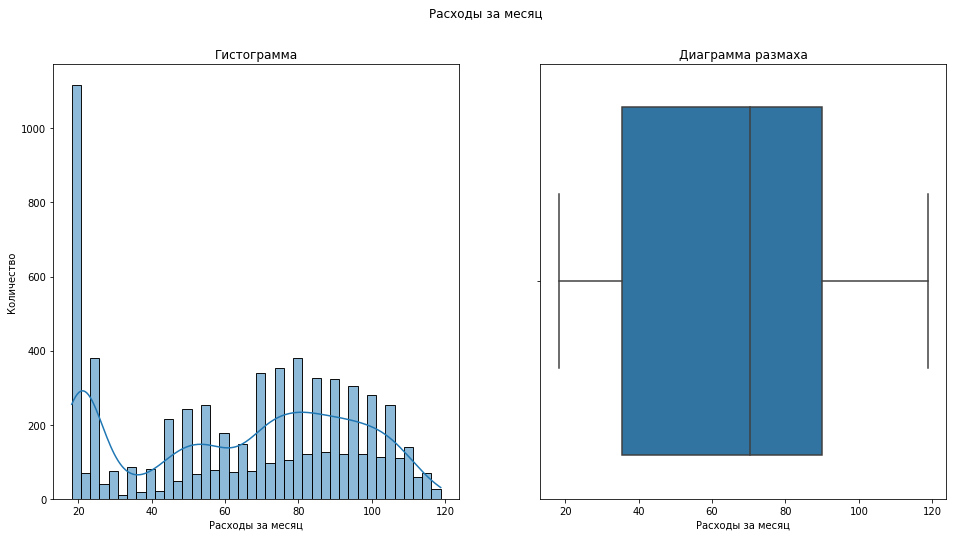

In [36]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data,x = 'MonthlyCharges', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Расходы за месяц')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data,x = 'MonthlyCharges', ax=axs[1])
axs[1].set_xlabel('Расходы за месяц')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Расходы за месяц')
plt.show()

Очень многие имеют минимальные расходы за месяц, далее количество людей в зависимости от расходов примерно одинаково. Людей, с самым большим количеством расходов за месяц - минимальное число.

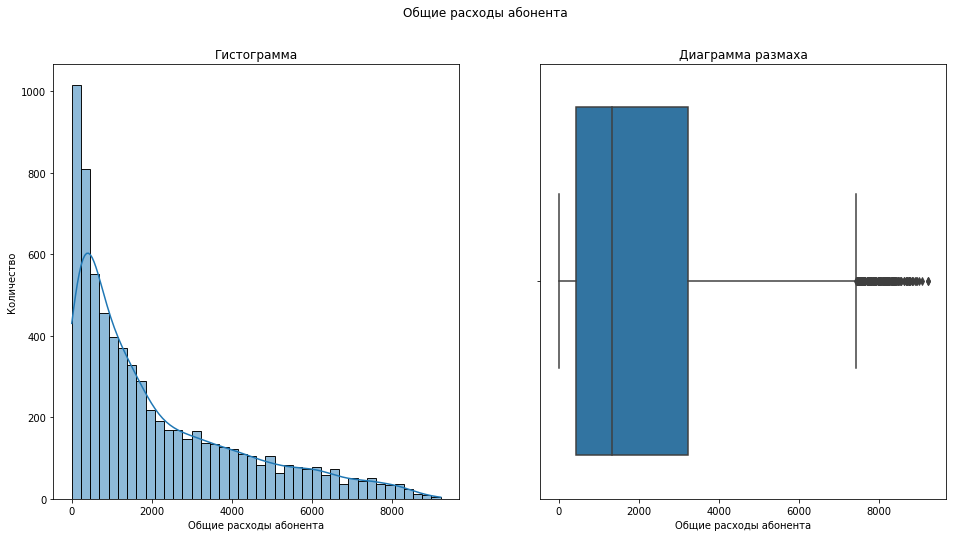

In [37]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data,x = 'TotalCharges', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Общие расходы абонента')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data,x = 'TotalCharges', ax=axs[1])
axs[1].set_xlabel('Общие расходы абонента')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Общие расходы абонента')
plt.show()

Количество абонентов уменьшается по мере роста расходов. 75% абонентов имеют расходы не более 3258.27

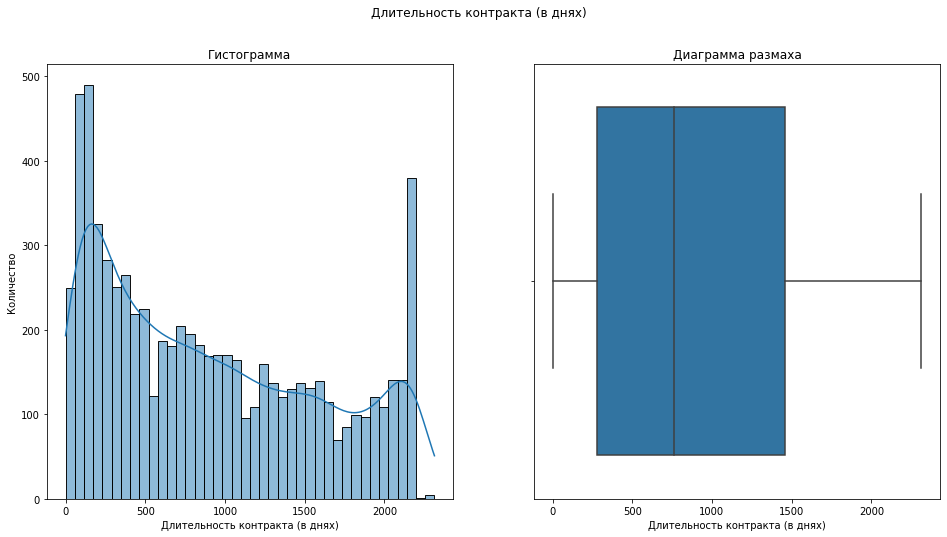

In [38]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data,x = 'days_difference', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Длительность контракта (в днях)')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data,x = 'days_difference', ax=axs[1])
axs[1].set_xlabel('Длительность контракта (в днях)')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Длительность контракта (в днях)')
plt.show()

Пики приходятся на 200-300 дней (относительно новые пользователи) и ~2300 дней (пользуются услугами уже давно). Звучит логично: если новый пользователь разочаровывается в услугах он уходит, из-за чего к 500 дням наблюдается спад. И есть те, кого всё устраивает, они то и остаются.

In [39]:
palette_color = sns.color_palette('bright') 
def vis_cat(name): # Принимает на вход название категориального столбца и визуализирует круговую диаграмму
    data[name].value_counts().plot(y = 'count', kind = 'pie', autopct='%1.0f%%', title = name, colors = palette_color, figsize = (14, 6))
    plt.show()

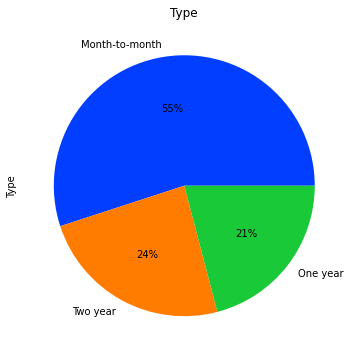

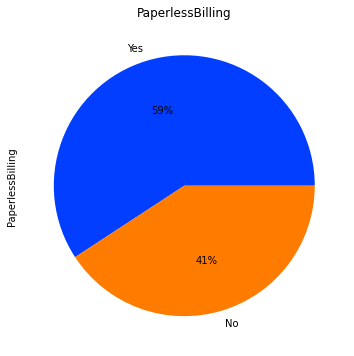

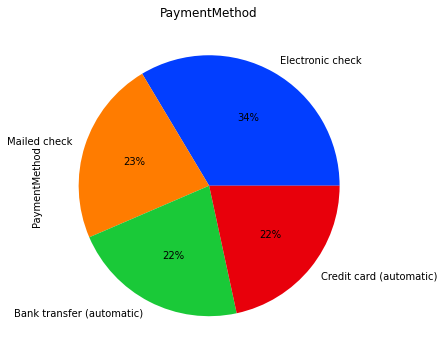

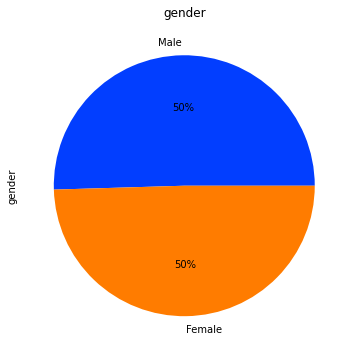

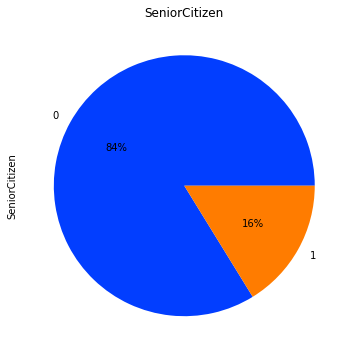

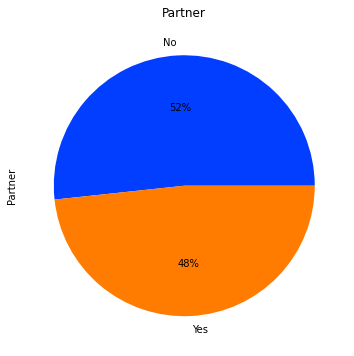

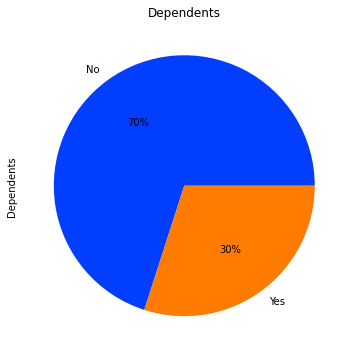

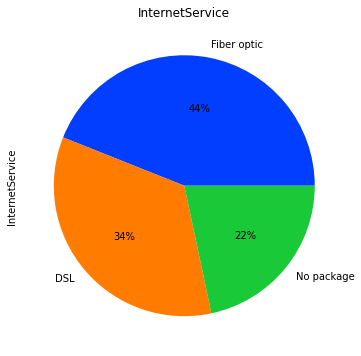

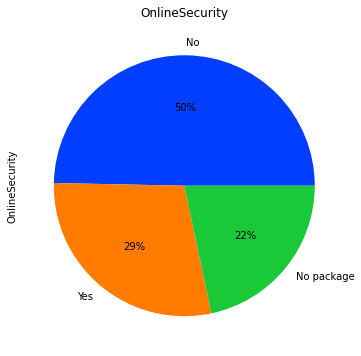

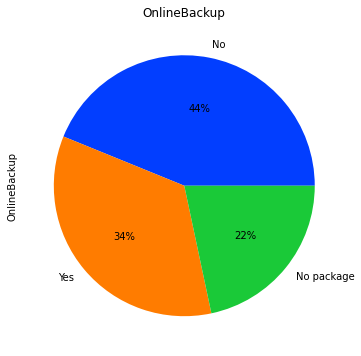

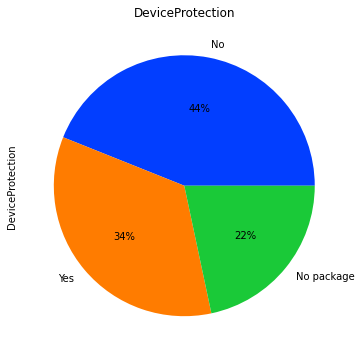

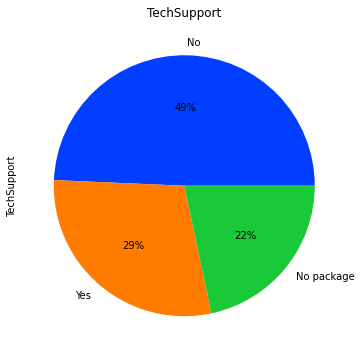

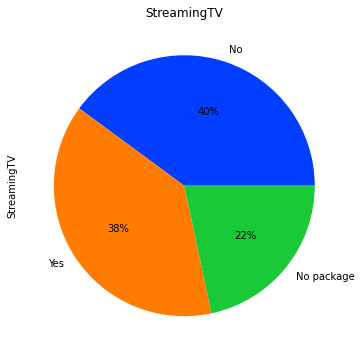

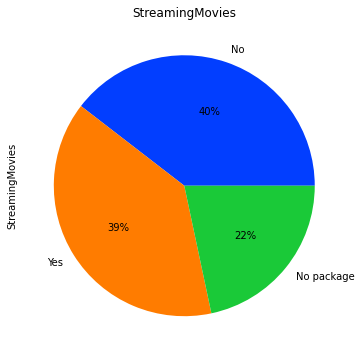

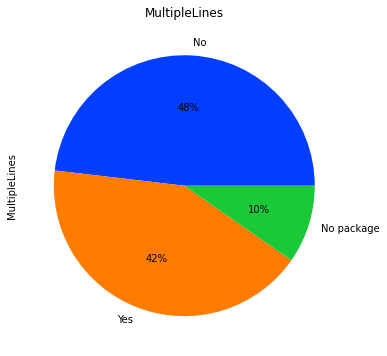

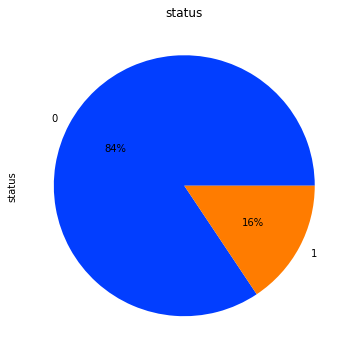

In [40]:
cat = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'status']
for name in cat:
    vis_cat(name)

- Большинство пользователей платят раз в месяц (половина)
- Методы платежа распределены практически поровну: Electronic check 34%, остальные 22-23%
- Соотношение мужчин и женщин равное
- 16% пользователей - пенсионеры
- Есть или нет партнёра распределение равное
- У 70% абонентов нет детей
- У 22% пользователей нет пакета с интернетом. Тип подключения +- распределён поровну
- У 10% пользователей нет пакета с телефонными услугами. Почти половина пользователей не имеют подключение телефона к нескольким линиям одновременно.


Были изучены графики, соотношения классов. Выбросов и аномалий не обнаружено. 

Если говорить про дисбаланс классов целевого признака: 84%/16%. В работе я буду использовать метрику ROC-AUC, она не чувствительна к дисбалансу, так что делать ничего с этим не надо.

### Матрица корреляции

In [41]:
data = data.drop(['BeginDate', 'EndDate'], axis=1) #Удалим даты

In [42]:
data.phik_matrix(interval_cols = ['MonthlyCharges', 'TotalCharges', 'days_difference']).style.background_gradient(cmap ='coolwarm')

Если говорить про коллинеарность: есть коллинеарность между месячными расходами и подключёнными услугами, но она почти нигде не превышает 0.9, так что трогать не будем. Также есть высокая коллинеарность между различными услугами, т.к. как правило подключая одну услугу, пользователи подключают и другие. Поэтому заменим эти столбцы одним: количеством подключённых услуг.

In [43]:
sp = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
data['internet_count'] = data[sp].apply(lambda row: (row == 'Yes').sum(), axis=1)
data = data.drop(sp, axis=1)

In [44]:
data.head()

Type PaperlessBilling              PaymentMethod  \
customerID                                                               
7590-VHVEG  Month-to-month              Yes           Electronic check   
5575-GNVDE        One year               No               Mailed check   
3668-QPYBK  Month-to-month              Yes               Mailed check   
7795-CFOCW        One year               No  Bank transfer (automatic)   
9237-HQITU  Month-to-month              Yes           Electronic check   

            MonthlyCharges  TotalCharges  gender SeniorCitizen Partner  \
customerID                                                               
7590-VHVEG           29.85         31.04  Female             0     Yes   
5575-GNVDE           56.95       2071.84    Male             0      No   
3668-QPYBK           53.85        226.17    Male             0      No   
7795-CFOCW           42.30       1960.60    Male             0      No   
9237-HQITU           70.70        353.50  Female             0      No   

           Dependents MultipleLines  status  days_difference  internet_count  
customerID                                                                    
7590-VHVEG         No    No package       0               31               1  
5575-GNVDE         No            No       0             1036               2  
3668-QPYBK         No            No       0              123               2  
7795-CFOCW         No    No package       0             1371               3  
9237-HQITU         No            No       0              153               0

In [45]:
data.phik_matrix(interval_cols = ['MonthlyCharges', 'TotalCharges', 'days_difference']).style.background_gradient(cmap ='coolwarm')

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   object 
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   MultipleLines     7043 non-null   object 
 10  status            7043 non-null   int64  
 11  days_difference   7043 non-null   int64  
 12  internet_count    7043 non-null   int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 1.0+ MB


In [47]:
data.describe()

MonthlyCharges  TotalCharges       status  days_difference  \
count     7043.000000   7043.000000  7043.000000      7043.000000   
mean        64.761692   2115.312885     0.156325       898.555729   
std         30.090047   2112.742814     0.363189       683.130510   
min         18.250000      0.000000     0.000000         0.000000   
25%         35.500000    436.750000     0.000000       276.000000   
50%         70.350000   1343.350000     0.000000       761.000000   
75%         89.850000   3236.690000     0.000000      1461.000000   
max        118.750000   9221.380000     1.000000      2314.000000   

       internet_count  
count     7043.000000  
mean         2.037910  
std          1.847682  
min          0.000000  
25%          0.000000  
50%          2.000000  
75%          3.000000  
max          6.000000

## Написание пайплайнов. Подготовка данных и обучение модели

In [48]:
ohe_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']
num_columns = ['MonthlyCharges', 'TotalCharges', 'days_difference', 'internet_count']
RANDOM_STATE = 160924

y = data['status']
X = data.drop(['status'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE,
        test_size=0.25
) 

In [49]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [50]:
ohe_pipe_2 = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        )
    ]
) 

In [51]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [52]:
data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe_2, ohe_columns)
    ], 
    remainder='passthrough'
) 

In [53]:
pipe_final_1= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [54]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [55]:
param_distributions_1 = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 

In [56]:
param_distributions_2 = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11)
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 150],
        'models__max_features': ['auto', 'sqrt', 'log2']
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE)],
        'models__iterations': range(100, 3000, 100),
        'models__learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5],
        'models__depth': range(2, 8, 1)
    }
] 

In [57]:
randomized_search_1 = RandomizedSearchCV(
    pipe_final_1, 
    param_distributions_1, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_1.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'gender',
                                                                                'SeniorCitizen...
                                         'models__C': range(1, 10),
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=160924)],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=160924, scoring='roc_auc')

In [58]:
randomized_search_1.best_score_

0.7752120391181554

In [59]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_distributions_2, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_2.fit(X_train, y_train)

0:	learn: 0.6047385	total: 49.7ms	remaining: 1m 34s
1:	learn: 0.5433579	total: 51.7ms	remaining: 49s
2:	learn: 0.4958866	total: 53.9ms	remaining: 34.1s
3:	learn: 0.4599545	total: 56.3ms	remaining: 26.7s
4:	learn: 0.4329263	total: 58.7ms	remaining: 22.3s
5:	learn: 0.4118485	total: 61ms	remaining: 19.3s
6:	learn: 0.3925287	total: 62.9ms	remaining: 17s
7:	learn: 0.3806934	total: 65.4ms	remaining: 15.5s
8:	learn: 0.3664369	total: 67.8ms	remaining: 14.2s
9:	learn: 0.3561737	total: 70.2ms	remaining: 13.3s
10:	learn: 0.3478516	total: 72.6ms	remaining: 12.5s
11:	learn: 0.3415956	total: 74.9ms	remaining: 11.8s
12:	learn: 0.3396318	total: 76ms	remaining: 11s
13:	learn: 0.3342740	total: 78.4ms	remaining: 10.6s
14:	learn: 0.3301433	total: 80.8ms	remaining: 10.2s
15:	learn: 0.3263037	total: 83.2ms	remaining: 9.8s
16:	learn: 0.3227680	total: 85.6ms	remaining: 9.48s
17:	learn: 0.3194133	total: 88.2ms	remaining: 9.22s
18:	learn: 0.3164150	total: 90.8ms	remaining: 8.99s
19:	learn: 0.3141766	total: 93.3

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               ['Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'gender',
                                                                                'SeniorCitizen',
                                                                                'P...
                                        {'models': [RandomForestClassifier(random_state=160924)],
                                         'models__max_features': ['auto',
                                                                  'sqrt',
                                                                  'log2'],
                                         'models__n_estimators': [50, 100,
                                                                  150]},
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x7f03fa9964c0>],
                                         'models__depth': range(2, 8),
                                         'models__iterations': range(100, 3000, 100),
                                         'models__learning_rate': [0.01, 0.03,
                                                                   0.05, 0.07,
                                                                   0.1, 0.3,
                                                                   0.5]}],
                   random_state=160924, scoring='roc_auc')

In [60]:
randomized_search_2.best_score_ #Метрика лучшей модели на кросс-валидации

0.9193553876876004

In [61]:
check = DummyClassifier()
check.fit(X_train, y_train)
check_pr = check.predict(y_test)
roc_auc_score(y_test, check_pr)

0.5

In [62]:
best_model = randomized_search_2.best_estimator_

In [63]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod', 'gender',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x7f03fa990cd0>)])

На константной модели метрика меньше, модель обучена не зря

In [64]:
y_predict_2 = best_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_predict_2)

0.9275811038915995

Значение метрики получилось довольно небольшим и что-то причин этому я не особо наблюдаю, скорее всего что-то где-то упустил и не вижу что. Поэтому решил отправить проект таким, ибо переходить к дальнейшим этапам пока смысла нет

## Проведём анализ модели


### Важность признаков

 97%|=================== | 5143/5282 [00:32<00:00]       

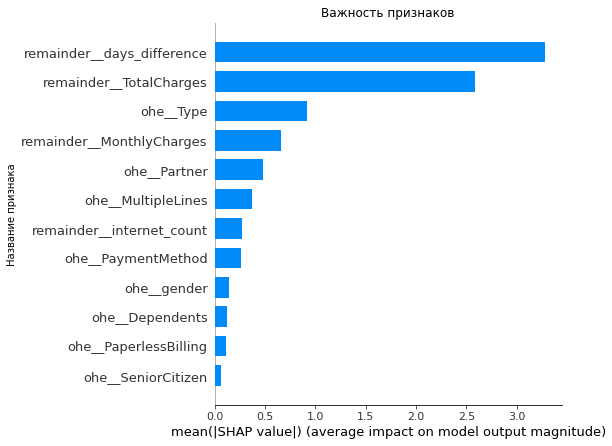

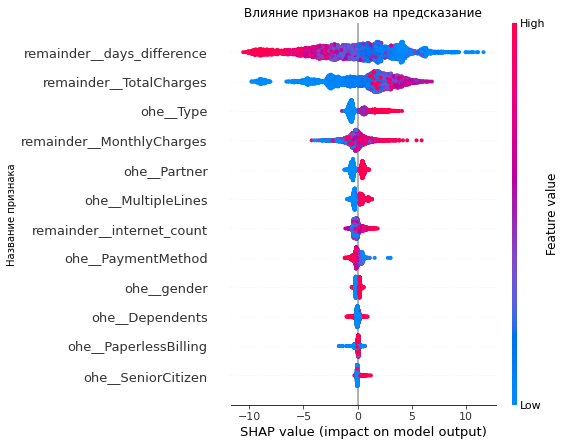

In [65]:
X_train_processed = best_model.named_steps['preprocessor'].transform(X_train)
feature_names = best_model['preprocessor'].get_feature_names_out()
data = pd.DataFrame(X_train_processed,\
                   columns=feature_names)

explainer = shap.TreeExplainer(best_model.named_steps['models'], data)
shap_values = explainer.shap_values(data)



plt.ylabel("Название признака")
plt.title("Важность признаков")
shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names, plot_type="bar", max_display=15)


plt.ylabel("Название признака")
plt.title("Влияние признаков на предсказание")
shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names, max_display=15)


**Выводы:**
1) Малозначимые признаки:\
    - Является ли абонент пенсионером\
    - Электронный расчётный лист\
    - Наличие детей\
 \
2) Наиболее значимые признаки:\
    - Длительность договора\
    - Общие затраты\
    - Тип оплаты (раз в год, по месяцам)\
\
**При моделировании и принятии бизнесс-решений:**
- Длительность договора сильнее всего влияет, так что стоит задуматься о каких-то предложениях для лучшего удержания новых абонентов и специальные предложения для "старичков", чтобы они продолжали пользоваться услугами компании.
- Меньше уделять внимания личным подробностям абонента: пенсионер, есть ли дети. Это оказывает наименьшее влияние
- Количество расходов (суммарное, ежемесячное) тоже оказывает влияние: можно задуматься о каких-либо предложениях, в целя уменьшения расходов с минимальными потерями для компании


### Матрица ошибок

In [66]:
cm = confusion_matrix(y_test, np.round(y_predict_2))

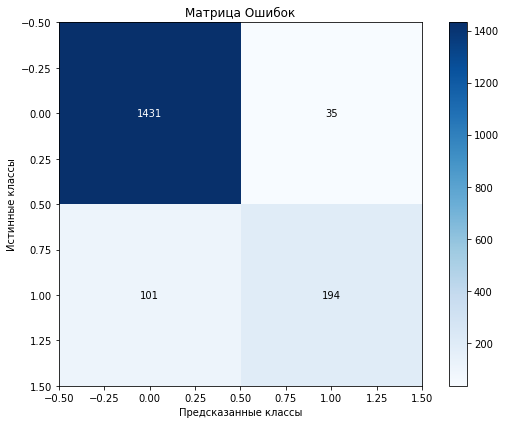

In [67]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Матрица Ошибок")
plt.colorbar()
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.tight_layout()
plt.show()

1431 раз было правильно предсказано, что абонент не будет разрывать контракт и продолжит работу с компанией, 194 раза был верно предсказан уход человека из компании. Количество ошибок FN: 101, FP: 35.
Далее, если бизнесу будет необходимо, он может изменить пороги классификации, для изменения баланса FN и FP

## Выводы

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Моя задача — обучить на этих данных модель для прогноза оттока клиентов.\
В рамках данной работы был проведена предобработка данных, исследовательский анализ данных, написание пайплайнов, поиск лучшей модели и гиперпараметров. Такой оказалась: CatBoostClassifier. После чего был проведён анализ важности признаков.

1) Малозначимые признаки:\
    - Является ли абонент пенсионером\
    - Электронный расчётный лист\
    - Наличие детей\
 \
2) Наиболее значимые признаки:\
    - Длительность договора\
    - Общие затраты\
    - Тип оплаты (раз в год, по месяцам)\
\
**При моделировании и принятии бизнесс-решений:**
- Длительность договора сильнее всего влияет, так что стоит задуматься о каких-то предложениях для лучшего удержания новых абонентов и специальные предложения для "старичков", чтобы они продолжали пользоваться услугами компании.
- Меньше уделять внимания личным подробностям абонента: пенсионер, есть ли дети. Это оказывает наименьшее влияние
- Количество расходов (суммарное, ежемесячное) тоже оказывает влияние: можно задуматься о каких-либо предложениях, в целя уменьшения расходов с минимальными потерями для компании